# 2 Naive Bayes

We decided to classify 1 and 7 instead of 9 and 3, since the dimension
reduction from last week does not make any sense for 3 and 9.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
import sklearn

digits = load_digits()

data = digits["data"][np.logical_or(digits["target"]==1, digits["target"]==7)]
target = digits["target"][np.logical_or(digits["target"]==1, digits["target"]==7)]

classes = np.unique(target)

n = data.shape[0]//5

train_data = data[:3*n]
train_target = target[:3*n]

test_data = data[3*n:]
test_target = target[3*n:]

def reduce_dim(x):
    x = np.copy(x)
    feature1 = x
    feature1.shape = feature1.shape[0],8,8
    feature1 = feature1.var(axis=1).mean(axis=1) + feature1.var(axis=1).min(axis=1)
    
    feature2 = 0.7 * x[:,2,3] + 0.3 * x[:,7,4]
    
    return np.stack((feature1, feature2), axis=1)

reduced_train = reduce_dim(train_data)
reduced_test = reduce_dim(test_data)

In [2]:
def fit_naive_bayes(features, labels, bincount=0):
    if bincount == 0:
        def gen_bin_widths():
            for l in np.unique(labels):
                x = features[labels==l]
                pct = np.percentile(x, (25, 75), axis=0)
                yield 2*np.subtract(pct[1], pct[0])
                
        widths = 2*np.stack(
            gen_bin_widths()
        )/np.cbrt(np.unique(labels).shape[0])
                
        def gen_bincounts():
            for l in np.unique(labels):
                x = features[labels==l]
                yield np.subtract(x.max(axis=0), x.min(axis=0))

        
        
        bincount = np.round(np.mean(
            np.ceil(
                np.stack(
                    gen_bincounts()
                )/widths
            )
        )).astype(int)        
    else:
        widths = np.zeros((np.unique(labels).shape[0], features.shape[1]))
        
    def gen_binning():
        for i,l in enumerate(np.unique(labels)):
            x = features[labels==l]
            yield np.stack(
                (x.min(axis=0),
                 np.maximum((x.max(axis=0)-x.min(axis=0)+0.001)/bincount, widths[i])),
                axis=0
            ).T
    
    binning = np.stack(
        gen_binning()
    )
    
    binning[binning[:,:,1]==0,1] = 1
        
    histograms = np.zeros(
        (np.unique(labels).shape[0], features.shape[1], bincount)
    )
    for i,l in enumerate(np.unique(labels)):
        x = features[labels==l]
        bins = np.floor(
            (x - binning[i,:,0])/binning[i,:,1]
        ).astype(int)
        for j in range(x.shape[0]):
            for k,l in enumerate(bins[j]):
                histograms[i, k, l] += 1
        histograms[i] /= x.shape[0]
        
    return histograms, binning

In [3]:
def predict_naive_bayes(test_features, histograms, binning):
    def gen_bins():
        for i in range(binning.shape[0]):
            bins = np.floor(
                (test_features - binning[i,:,0])/binning[i,:,1]
            ).astype(int)
            for j in range(test_features.shape[0]):
                for k,l in enumerate(bins[j]):
                    if l >= histograms.shape[2]:
                        yield histograms[i, k, -1]
                    else:
                        yield histograms[i, k, l]

    likelihoods = np.fromiter(
        gen_bins(),
        np.float
    )
    likelihoods.shape = histograms.shape[0], test_features.shape[0], histograms.shape[1]
    
    preds = np.argmax(np.sum(np.log(likelihoods), axis=-1), axis=0)
    
    return classes[preds]

In [4]:
import pandas as pd
pd.crosstab(test_target, predict_naive_bayes(test_data, *fit_naive_bayes(train_data, train_target, bincount=8)),
            rownames=['Actual'], colnames=['Predicted'])

/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


Predicted   1   7
Actual           
1          69   4
7          19  53

/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


Predicted   1   7
Actual           
1          70   3
7           1  71

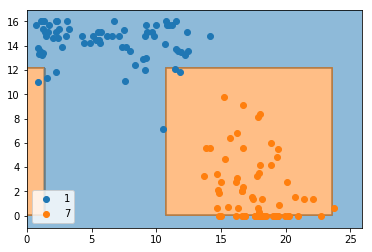

In [5]:
display(pd.crosstab(test_target, predict_naive_bayes(reduced_test, *fit_naive_bayes(reduced_train, train_target, bincount=0)),
            rownames=['Actual'], colnames=['Predicted']))

x = np.arange(0, 26, 26/200)
y = np.arange(-1, 17, 18/200)

xx, yy = np.meshgrid(x,y)
grid = np.column_stack((xx.flatten(), yy.flatten()))

histograms, binning = fit_naive_bayes(reduced_train, train_target,bincount=0)

grid_labels = predict_naive_bayes(grid, histograms, binning)
grid_labels.shape = 200,200

plt.contourf(xx, yy, grid_labels, alpha=0.5, colors=('C0','C1'))
plt.scatter(*reduced_test[test_target == 1].T, label='1')
plt.scatter(*reduced_test[test_target == 7].T, label='7')
plt.legend(loc=3)
plt.show()